In [81]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from glob import glob
import xarray as xr
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "7"
from keras.models import load_model
from keras.utils import plot_model
from deepsky.gan import gan_loss, rescale_data, rescale_multivariate_data, unscale_multivariate_data
from IPython.display import Image
from netCDF4 import Dataset
import h5py
from os.path import join

In [59]:
def load_storm_patch_data(data_path, variable_names):
    data_patches = []
    data_files = sorted(glob(join(data_path, "*20160526*.nc")))
    for data_file in data_files:
        print(data_file.split("/")[-1])
        ds = xr.open_dataset(data_file)
        patch_arr = []
        for variable in variable_names:
            patch_arr.append(ds[variable].values)
        data_patches.append(np.stack(patch_arr, axis=-1))
    data = np.vstack(data_patches)
    return data

In [66]:
data_path = "/scratch/dgagne/ncar_ens_storm_patches/"
variable_names = ["composite_reflectivity_entire_atmosphere_prev",
                  "temperature_2_m_above_ground_prev",
                  "dew_point_temperature_2_m_above_ground_prev",
                  "u-component_of_wind_10_m_above_ground_prev",
                  "v-component_of_wind_10_m_above_ground_prev"]
storm_data = load_storm_patch_data(data_path, variable_names)
scaled_storm_data = rescale_multivariate_data(storm_data)

ncar_ens_storm_patches_2016052600_mem_01.nc
ncar_ens_storm_patches_2016052600_mem_02.nc
ncar_ens_storm_patches_2016052600_mem_03.nc
ncar_ens_storm_patches_2016052600_mem_04.nc
ncar_ens_storm_patches_2016052600_mem_05.nc
ncar_ens_storm_patches_2016052600_mem_06.nc
ncar_ens_storm_patches_2016052600_mem_07.nc
ncar_ens_storm_patches_2016052600_mem_08.nc
ncar_ens_storm_patches_2016052600_mem_09.nc
ncar_ens_storm_patches_2016052600_mem_10.nc


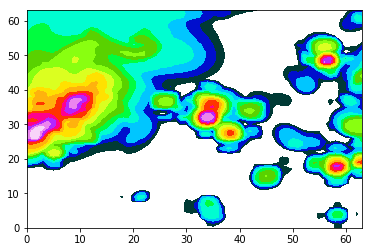

In [75]:
plt.contourf(storm_data[203, :, :, 0], np.arange(0, 80, 5), cmap="gist_ncar")

In [247]:
gan_history_files = sorted(glob("/scratch/dgagne/storm_gan_20170615/gan_loss_history_*.csv"))
gan_history_coll = []
for gan_history_file in gan_history_files:
    print(gan_history_file)
    gan_history_coll.append(pd.read_csv(gan_history_file, index_col="Time", parse_dates=["Time"]))

/scratch/dgagne/storm_gan_20170615/gan_loss_history_000.csv
/scratch/dgagne/storm_gan_20170615/gan_loss_history_001.csv
/scratch/dgagne/storm_gan_20170615/gan_loss_history_002.csv
/scratch/dgagne/storm_gan_20170615/gan_loss_history_003.csv
/scratch/dgagne/storm_gan_20170615/gan_loss_history_004.csv
/scratch/dgagne/storm_gan_20170615/gan_loss_history_005.csv


[   0  892 1784 2676 3568 4460 5352 6244 7136 8028]
[   0  892 1784 2676 3568 4460 5352 6244 7136 8028]
[   0  892 1784 2676 3568 4460 5352 6244 7136 8028]
[   0  892 1784 2676 3568 4460 5352 6244 7136 8028]
[   0  892 1784 2676 3568 4460 5352 6244 7136 8028]
[   0  892 1784 2676 3568 4460 5352 6244 7136 8028]


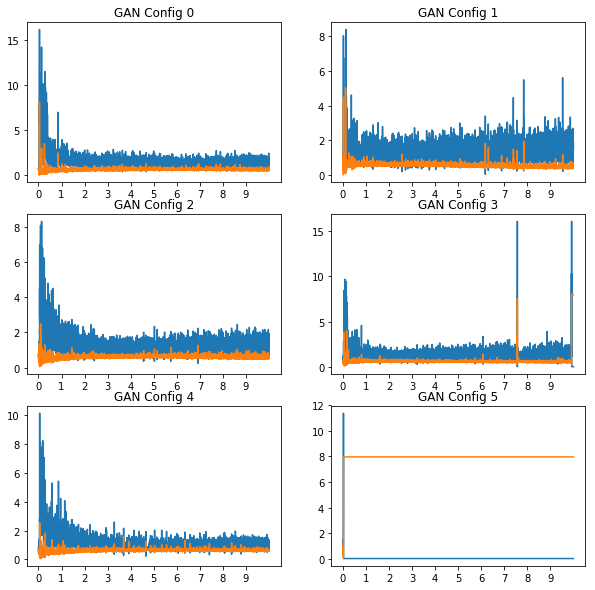

In [248]:
fig, axes = plt.subplots(3,2, figsize=(10, 10))
axef = axes.ravel()
for g in range(len(gan_history_coll)):
    axef[g].plot(np.arange(gan_history_coll[g].shape[0]), gan_history_coll[g]["Gen Loss"])
    axef[g].plot(np.arange(gan_history_coll[g].shape[0]), gan_history_coll[g]["Disc Loss"])
    epoch_vals = np.where(gan_history_coll[g]["Batch"].values == 0)[0]
    print(epoch_vals)
    axef[g].set_xticks(epoch_vals)
    axef[g].set_xticklabels(gan_history_coll[g].iloc[epoch_vals]["Epoch"].values.astype(int) - 1)
    #axef[g].set_yscale("log")
    axef[g].set(title="GAN Config {0:d}".format(g))

[   0  892 1784 2676 3568 4460 5352 6244 7136 8028]
[   0  892 1784 2676 3568 4460 5352 6244 7136 8028]
[   0  892 1784 2676 3568 4460 5352 6244 7136 8028]
[   0  892 1784 2676 3568 4460 5352 6244 7136 8028]
[   0  892 1784 2676 3568 4460 5352 6244 7136 8028]
[   0  892 1784 2676 3568 4460 5352 6244 7136 8028]


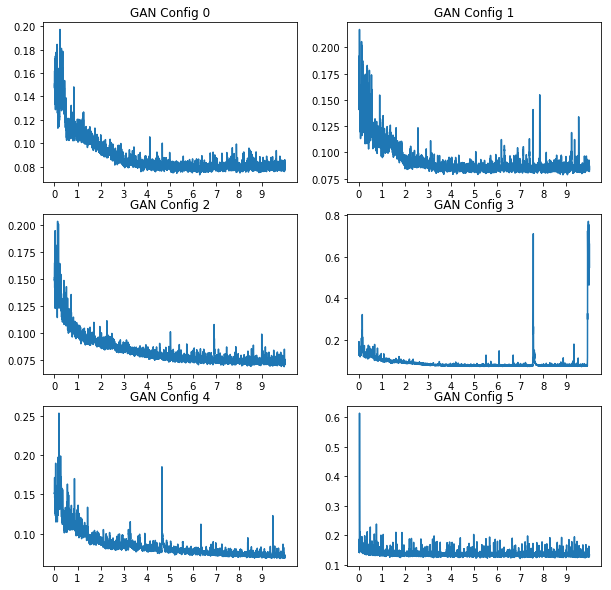

In [204]:
fig, axes = plt.subplots(3,2, figsize=(10, 10))
axef = axes.ravel()
for g in range(len(gan_history_coll)):
    axef[g].plot(np.arange(gan_history_coll[g].shape[0]), gan_history_coll[g]["Gen_Enc Loss"])
    epoch_vals = np.where(gan_history_coll[g]["Batch"].values == 0)[0]
    print(epoch_vals)
    axef[g].set_xticks(epoch_vals)
    axef[g].set_xticklabels(gan_history_coll[g].iloc[epoch_vals]["Epoch"].values.astype(int) - 1)
    #axef[g].set_yscale("log")
    axef[g].set(title="GAN Config {0:d}".format(g))

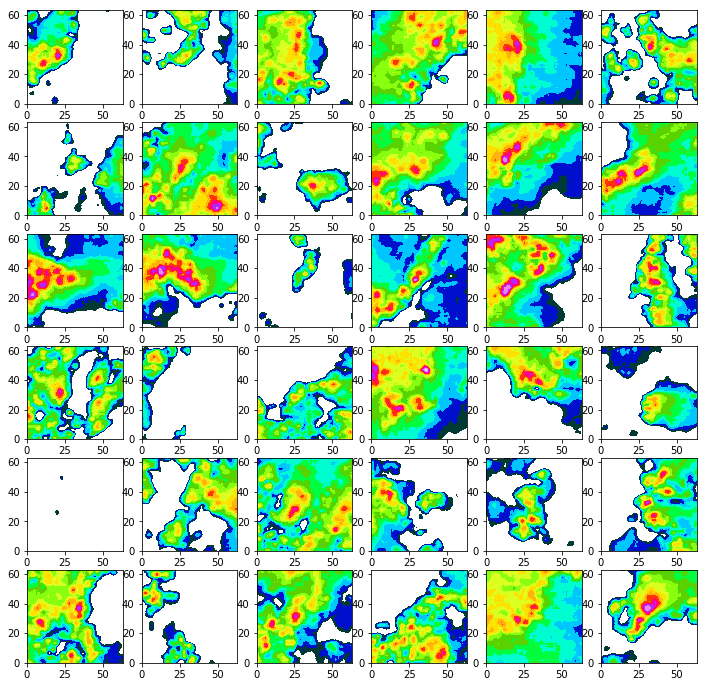

In [205]:
ds = xr.open_dataset("/scratch/dgagne/storm_gan_20170615/gan_gen_patches_002_epoch_010.nc")
fig, axes = plt.subplots(6,6, figsize=(12, 12))
axef = axes.ravel()
for a, ax in enumerate(axef):
    ax.contourf(ds["gen_patch"][a, :, :, 0], np.arange(0, 80, 5), cmap="gist_ncar")
ds.close()

In [206]:
gan_param_configs = pd.read_csv("/scratch/dgagne/storm_gan_20170615/gan_param_combos.csv")
gan_param_configs

,Index,min_data_width,learning_rate,beta_one,filter_width,generator_input_size,min_conv_filters,batch_size
0,0,4,0.0001,0.2,5,16,64,256
1,1,4,0.0001,0.2,5,16,128,256
2,2,4,0.0001,0.2,5,32,64,256
3,3,4,0.0001,0.2,5,32,128,256
4,4,4,0.0001,0.2,5,128,64,256
5,5,4,0.0001,0.2,5,128,128,256


In [228]:

enc= load_model("/scratch/dgagne/storm_gan_20170615/gan_encoder_000004_epoch_0010.h5")
gen = load_model("/scratch/dgagne/storm_gan_20170615/gan_generator_000004_epoch_0010.h5")

In [191]:
max_vals = storm_data.max(axis=0).max(axis=0).max(axis=0)
min_vals = storm_data.min(axis=0).min(axis=0).min(axis=0)

In [229]:
enc_vecs = enc.predict(scaled_storm_data[104:204])
regen = unscale_multivariate_data(gen.predict(enc_vecs), min_vals, max_vals)

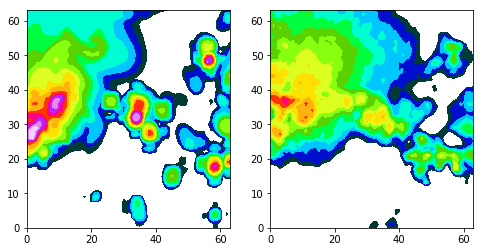

In [243]:
fig, axes = plt.subplots(1, 2, figsize=(8, 4))
axes[0].contourf(storm_data[203, :, :, 0], np.arange(0, 80, 5), cmap="gist_ncar")
axes[1].contourf(regen[-1, :, :, 0], np.arange(0, 80, 5), cmap="gist_ncar")


In [224]:
interp_vecs = np.zeros((12, enc_vecs.shape[1]))
interp_vecs[0] = enc_vecs[0]
interp_vecs[-1] = enc_vecs[-1]
for i in range(interp_vecs.shape[1]):
    interp_vecs[:, i] = np.linspace(interp_vecs[0, i], interp_vecs[-1, i], 12)

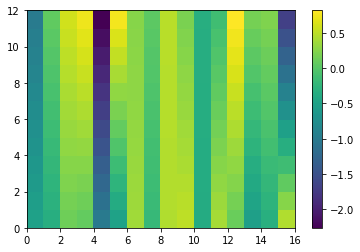

In [242]:
plt.pcolormesh(interp_vecs)
plt.colorbar()

In [225]:
interp_regen = unscale_multivariate_data(gen.predict(interp_vecs), min_vals, max_vals)

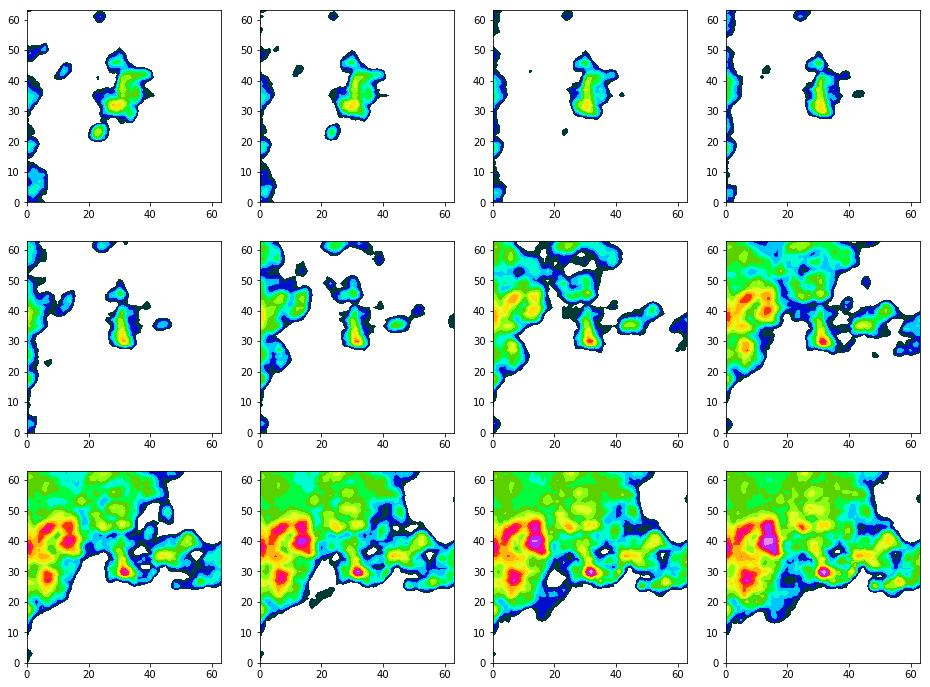

In [226]:
fig, axes = plt.subplots(3, 4, figsize=(16, 12))
axef = axes.ravel()
for a, ax in enumerate(axef):
    ax.contourf(interp_regen[a, :, :, 0], np.arange(0, 80, 5), cmap="gist_ncar")

In [238]:
input_const_vecs = np.tile(np.linspace(-1, 1, 20), 128).reshape(128, 20).T
print(input_const_vecs)

[[-1.         -1.         -1.         ..., -1.         -1.         -1.        ]
 [-0.89473684 -0.89473684 -0.89473684 ..., -0.89473684 -0.89473684
  -0.89473684]
 [-0.78947368 -0.78947368 -0.78947368 ..., -0.78947368 -0.78947368
  -0.78947368]
 ..., 
 [ 0.78947368  0.78947368  0.78947368 ...,  0.78947368  0.78947368
   0.78947368]
 [ 0.89473684  0.89473684  0.89473684 ...,  0.89473684  0.89473684
   0.89473684]
 [ 1.          1.          1.         ...,  1.          1.          1.        ]]


In [239]:
output_const_vecs = enc.predict(gen.predict(input_const_vecs))

In [235]:
output_const_vecs[15]

array([ -2.70239443e-01,   4.54484761e-01,  -4.25016224e-01,
         1.54800549e-01,   7.95009077e-01,  -5.59991717e-01,
        -4.18880045e-01,  -1.84379578e-01,  -4.58426476e-01,
        -7.63936520e-01,   6.96453094e-01,   3.09736371e-01,
         3.72111976e-01,  -3.27697903e-01,  -1.35622352e-01,
         3.07522893e-01,   1.91487145e+00,  -6.88715503e-02,
         6.31743729e-01,   1.28289378e+00,   6.80993021e-01,
         2.38614619e-01,  -7.74333596e-01,  -6.10474944e-01,
         2.36634225e-01,  -1.95706040e-01,   1.78812936e-01,
         1.97460055e-01,   1.86096981e-01,   6.29770219e-01,
        -5.96672297e-01,   4.52671558e-01,   7.34631002e-01,
        -6.77201748e-01,  -4.22205657e-01,  -1.10579282e-01,
        -1.57373503e-01,  -3.51284593e-01,   7.70734787e-01,
        -1.06331542e-01,  -6.11377135e-02,   2.40559220e-01,
         7.12119401e-01,   5.70223629e-01,   1.43129364e-01,
         3.18412185e-01,  -9.16561186e-01,   2.21023351e-01,
        -3.48179460e-01,

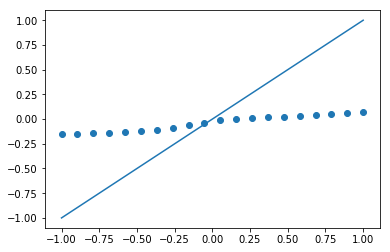

In [240]:
plt.scatter(input_const_vecs.mean(axis=1), output_const_vecs.mean(axis=1))
plt.plot(np.arange(-1, 1.1, 0.1), np.arange(-1, 1.1, 0.1))

In [24]:
plot_model(disc, to_file="/scratch/dgagne/storm_gan_20170517/gan_discriminator_000.png", show_shapes=True)

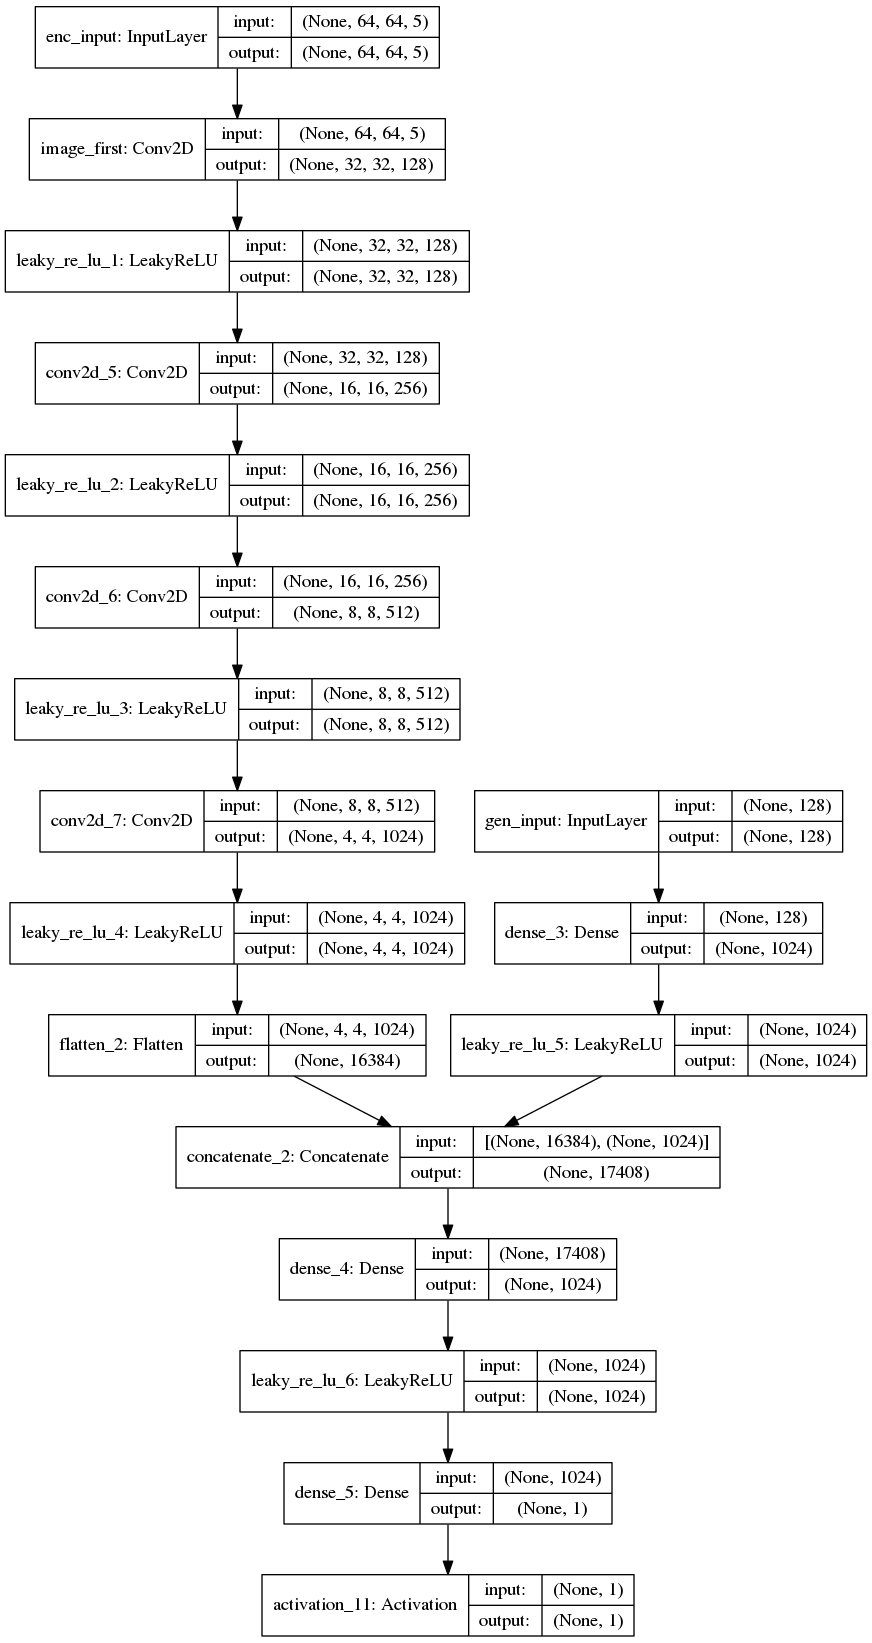

In [25]:
Image("/scratch/dgagne/storm_gan_20170517/gan_discriminator_000.png")

In [32]:
d = h5py.File("/scratch/dgagne/storm_gan_20170519/gan_encoder_000001_epoch_0010.h5")

In [44]:
dir(d)

['_MutableMapping__marker',
 '__abstractmethods__',
 '__bool__',
 '__class__',
 '__contains__',
 '__delattr__',
 '__delitem__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__enter__',
 '__eq__',
 '__exit__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__getitem__',
 '__gt__',
 '__hash__',
 '__init__',
 '__iter__',
 '__le__',
 '__len__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__nonzero__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__setitem__',
 '__sizeof__',
 '__slots__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_abc_cache',
 '_abc_negative_cache',
 '_abc_negative_cache_version',
 '_abc_registry',
 '_d',
 '_e',
 '_id',
 '_lapl',
 '_lcpl',
 'attrs',
 'clear',
 'close',
 'copy',
 'create_dataset',
 'create_group',
 'driver',
 'fid',
 'file',
 'filename',
 'flush',
 'get',
 'id',
 'items',
 'keys',
 'libver',
 'mode',
 'move',
 'name',
 'parent',
 'pop',
 'popitem',
 'ref',
 'regionref',
 'require_dataset',
 'require_group',
 'setdefault',
 'upd

In [46]:
for key in d.keys():
    print(key)

model_weights
optimizer_weights


In [66]:
list(d["model_weights"].keys())

['activation_10',
 'activation_6',
 'activation_7',
 'activation_8',
 'activation_9',
 'conv2d_1',
 'conv2d_2',
 'conv2d_3',
 'conv2d_4',
 'dense_2',
 'enc_input',
 'flatten_1']

In [77]:
list(d["model_weights"]["conv2d_1"]["conv2d_1"].keys())

['bias:0', 'kernel:0']